# ЗАНЯТИЕ 2.7. БУСТИНГ. ОБЗОР БИБЛИОТЕКИ XGBOOST

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings

warnings.filterwarnings('ignore')

#устраним ошибки со шрифтами
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

## Описание задачи

Используем данные страхового подразделения BNP Paribas из соревнования

https://www.kaggle.com/c/bnp-paribas-cardif-claims-management

Решается задача классификации страховых случаев:
    1. Случаи, требующие дополнительных документов для подтвердения (0)
    2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)


In [2]:
data = pd.read_csv('datasets/Paribas/train.csv')

In [3]:
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


Уменьшим объем данных для ускорения обучения, возьмем случайную подвыборку 20% данных со стратификацией

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

In [5]:
data.shape

(22865, 133)

Разбиение на обучение и hold-out тест 70/30. Данных достаточно много, поэтому можно принебречь честной кросс
валидацией

In [6]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=.3, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

# Первичный анализ

Размер датасета

In [7]:
d_train.shape

(16005, 133)

Распределение значний таргета (event rate)

In [8]:
d_train.target.value_counts() / len(d_train)

1    0.7612
0    0.2388
Name: target, dtype: float64

## Предобработка данных

Находим категориальные признаки

Чтобы в разы не увеличивать число признаков при построении dummy, будем использовать
категориальные признаки с < 30 уникальных значений

In [9]:
cat_feat = list(data.dtypes[data.dtypes == object].index)

# закодируем пропущенные значния строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

# отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3         3
v22     6610
v24        5
v30        7
v31        3
v47        9
v52       12
v56       90
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      22
v113      34
v125      88
dtype: int64


In [10]:
from sklearn.metrics import auc, roc_curve

### Создаем признаки для "деревянных" моделей

1. Замняем пропуски на специальное значение -999, чтобы деревья могли им отличить
2. Создаем дамми-переменные для категорий

In [11]:
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

X_train = pd.concat([d_train[num_feat].fillna(-999),
                    dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                   dummy_test], axis=1)

**Добавляем среднее значение таргфета внутри всех категориальных признаков по фолдам через стекинг**

In [12]:
y_train.groupby(d_train['v24']).mean()

v24
A    0.724346
B    0.770536
C    0.814266
D    0.749197
E    0.748129
Name: target, dtype: float64

In [13]:
class MeanClassifier():
    def __init__(self, col):
        self._col = col
        
    def fit(self, X, y):
        self._y_mean = y.mean()
        self._means = y.groupby(X[self._col].astype(str)).mean()
    
    def predict_proba(self, X):
        new_feature = X[self._col].astype(str)\
            .map(self._means.to_dict())\
            .fillna(self._y_mean)
        return np.stack([1-new_feature, new_feature], axis=1)

    
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict_proba(X_train.iloc[test_ind])[:, 1]
        meta_test += clf.predict_proba(X_test)[:, 1]
    
    return meta_train, meta_test / stack_cv.n_splits

from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=555)

meta_train = []
meta_test = []
col_names = []

for c in tqdm.tqdm(cat_nunique.index.tolist()):
    clf = MeanClassifier(c)
    
    meta_tr, meta_te = get_meta_features(clf, d_train, y_train, d_test, stack_cv)
    
    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    col_names.append(f'mean_pred_{c}')

X_mean_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names, index=d_train.index)
X_mean_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names, index=d_test.index)

X_train = pd.concat([X_train, X_mean_train], axis=1)
X_test = pd.concat([X_test, X_mean_test], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:06<00:00,  3.17it/s]


#### Считаем ROC AUC

In [14]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print(f'ROC AUC: {auc_val}' )
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

## Обучение моделей

### Случайный лес

Предсказываем вероятнсть класса 1 и считаем ROC AUC

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=50, max_depth=15, min_samples_leaf=20, max_features=.8, n_jobs=-1)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=0.8, min_samples_leaf=20,
                       n_estimators=50, n_jobs=-1)

Train:
ROC AUC: 0.9117191462672871
Test:
ROC AUC: 0.7294365811217591


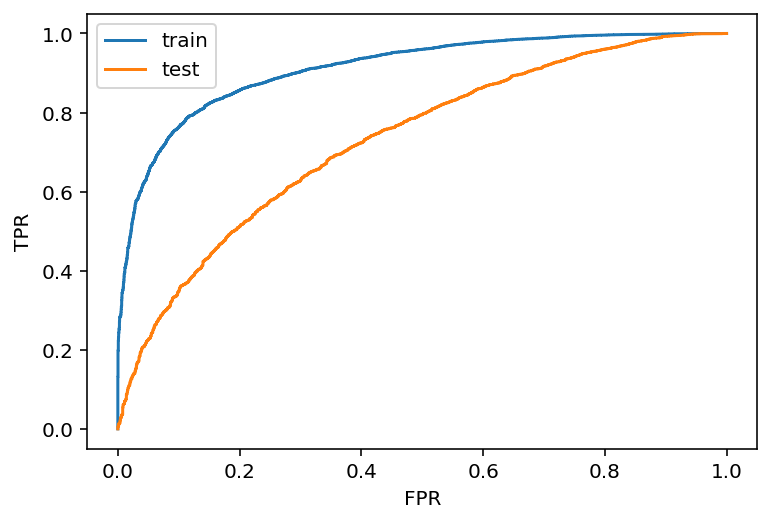

In [16]:
y_pred_rf_test = clf_rf.predict_proba(X_test)[:, 1]
y_pred_rf_train = clf_rf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_rf_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_rf_test, 'test')
plt.legend();

## Бустинг в sklearn

In [17]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

Adaboost

Train:
ROC AUC: 0.8001944809645236
Test:
ROC AUC: 0.7281200649641859


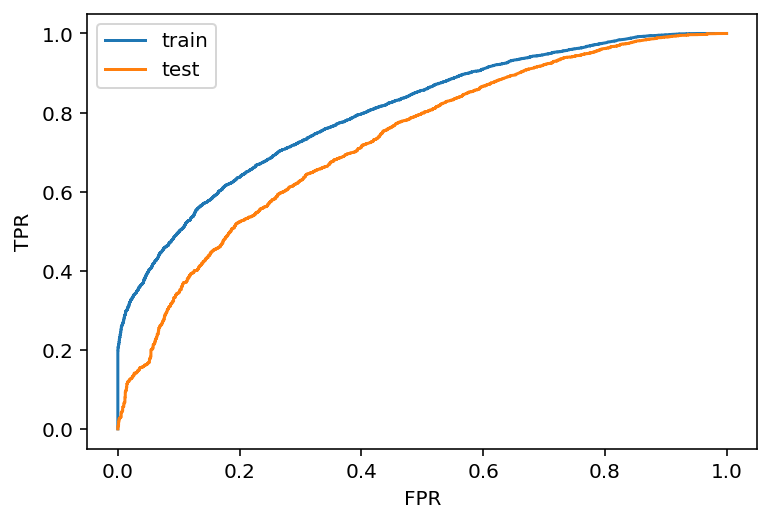

In [18]:
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, max_features=0.8), 
                             n_estimators=20, learning_rate=0.1)
clf_ada.fit(X_train, y_train)
y_pred_ada_test = clf_ada.predict_proba(X_test)[:, 1]
y_pred_ada_train = clf_ada.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_ada_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_ada_test, 'test')
plt.legend();

GradientBoosting

      Iter       Train Loss   Remaining Time 
         1           1.0724           11.83s
         2           1.0513           11.21s
         3           1.0335           10.60s
         4           1.0192            9.98s
         5           1.0064            9.36s
         6           0.9952            8.76s
         7           0.9858            8.14s
         8           0.9771            7.52s
         9           0.9697            6.89s
        10           0.9632            6.27s
        11           0.9575            5.64s
        12           0.9511            5.02s
        13           0.9458            4.39s
        14           0.9408            3.77s
        15           0.9365            3.15s
        16           0.9323            2.52s
        17           0.9288            1.89s
        18           0.9250            1.26s
        19           0.9219            0.63s
        20           0.9186            0.00s
Train:
ROC AUC: 0.7842724351940941
Test:
ROC AUC: 0.73

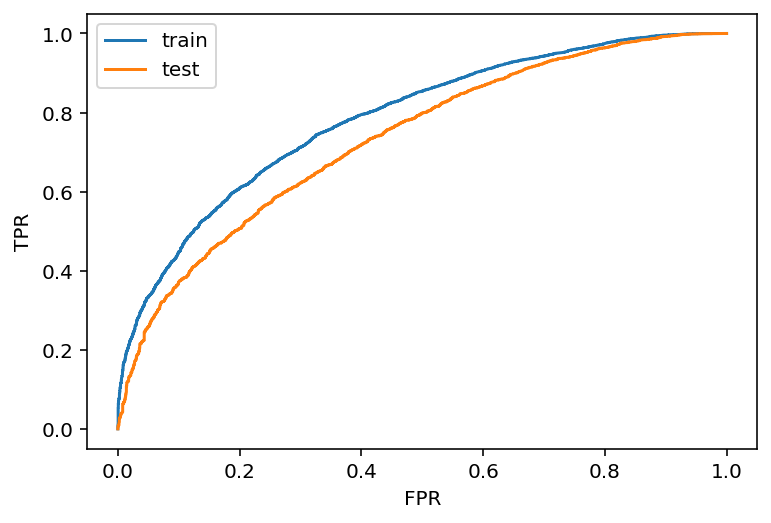

In [19]:
clf_gbm = GradientBoostingClassifier(max_depth=5, min_samples_leaf=20, max_features=0.8, 
                             n_estimators=20, learning_rate=0.1, verbose=2)
clf_gbm.fit(X_train, y_train)
y_pred_gbm_test = clf_gbm.predict_proba(X_test)[:, 1]
y_pred_gbm_train = clf_gbm.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_gbm_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_gbm_test, 'test')
plt.legend();

# XGBOOST

In [20]:
import xgboost as xgb

**Важные гиперпараметры алгоритма**

a. Параметры деревьев

    1. max_depth  - максимальная глубина дерева (обычно 3-10, больше глубина - большье
     риск переобучения)
    2. min_child_weight - минимальное число объектов в листе (обычно до 20, больше объектов -> меньше риск
     переобучения, но должен быть соглаван с глубиной дерева)
    3. gamma - минимально необходимый прирост качества для разбиения листа (редко используется

b. параметры бустинга

    0. objective - оптимизируемый функционал (встроен для классификации и регрессии, 
        можно написать свой, дифференцируемый
    1. n_estimators - к-во базовых алгоритмов (чем меньше learning_rate, тем больше
        деревьев)
    2. learning_rate - шаг создания ансамбля (зависит от n_estimators, но обчыно 0.01 
        - 01)
    3. subsample - доля объектов, случайно выбирающихся для построения дерева
    4. n_jobs - количество потоков для одновременного построения дерева
    5. reg_alpha - вес L1 регуляризации (редко используется)
    6. reg_lambda - вес L2 регуляризации (редко используется)

Параметры по умолчанию

In [21]:
params = {'n_estimators': 100,
          'learning_rate': .1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}

clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_train, y_train)

[18:17:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train:
ROC AUC: 0.7829156836526591
Test:
ROC AUC: 0.734642203619607


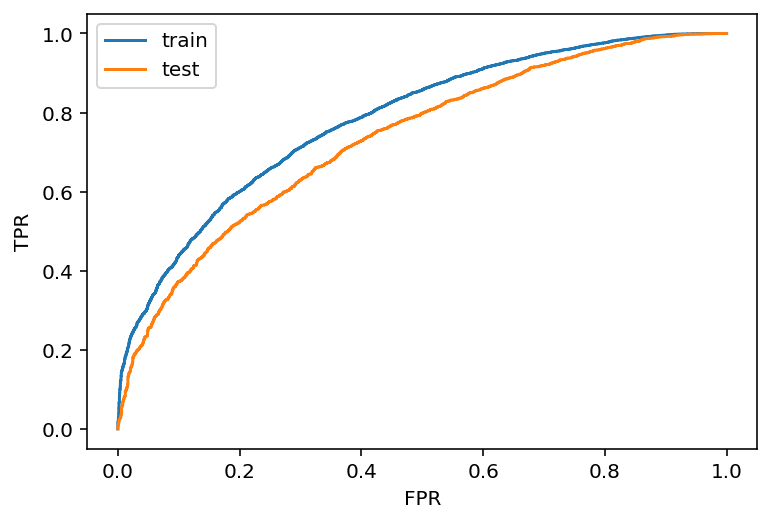

In [22]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.legend();

#### Онлайн оценка качетва

Во время обучения можно следить за качеством во время каждой итерации

Для этого используются параметры:

    1. eval_metric - метрика 'auc', 'rmse', 'logloss', ...
    2. eval_set - список выборок вида [(X, y), ...] на которых тестировать алгоритм

In [23]:
params = {'n_estimators': 100,
          'learning_rate': .1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}

clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.70552	validation_1-auc:0.70188
[1]	validation_0-auc:0.71203	validation_1-auc:0.70646
[2]	validation_0-auc:0.71381	validation_1-auc:0.70633
[3]	validation_0-auc:0.71435	validation_1-auc:0.70678
[4]	validation_0-auc:0.71870	validation_1-auc:0.71238
[5]	validation_0-auc:0.72328	validation_1-auc:0.71648
[6]	validation_0-auc:0.72363	validation_1-auc:0.71773
[7]	validation_0-auc:0.72585	validation_1-auc:0.71813
[8]	validation_0-auc:0.72679	validation_1-auc:0.71899
[9]	validation_0-auc:0.72929	validation_1-auc:0.72235
[10]	validation_0-auc:0.72951	validation_1-auc:0.72146
[11]	validation_0-auc:0.73152	validation_1-auc:0.72355
[12]	validation_0-auc:0.73249	validation_1-auc:0.72521
[13]	validation_0-auc:0.73333	validation_1-auc:0.72633
[14]	validation_0-auc:0.73404	validation_1-auc:0.72651
[15]	validation_0-auc:0.73511	validation_1-auc:0.72756
[16]	validation_0-auc:0.73554	validation_1-auc:0.72723
[17]	validation_0-auc:0.73631	validation_1-auc:0.72749
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Возьмем параметры, с которых лучше всего начать

In [24]:
params = {'n_estimators': 100,
          'learning_rate': .1,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': .8,
          'colsample_bytree': .8,
          'n_jobs': -1}

clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.72781	validation_1-auc:0.70106
[1]	validation_0-auc:0.74012	validation_1-auc:0.71195
[2]	validation_0-auc:0.75108	validation_1-auc:0.72274
[3]	validation_0-auc:0.75872	validation_1-auc:0.72889
[4]	validation_0-auc:0.76064	validation_1-auc:0.72882
[5]	validation_0-auc:0.76326	validation_1-auc:0.72921
[6]	validation_0-auc:0.76448	validation_1-auc:0.72879
[7]	validation_0-auc:0.76807	validation_1-auc:0.73089
[8]	validation_0-auc:0.76925	validation_1-auc:0.73165
[9]	validation_0-auc:0.76973	validation_1-auc:0.73203
[10]	validation_0-auc:0.77164	validation_1-auc:0.73311
[11]	validation_0-auc:0.77353	validation_1-auc:0.73344
[12]	validation_0-auc:0.77424	validation_1-auc:0.73381
[13]	validation_0-auc:0.77644	validation_1-auc:0.73343
[14]	validation_0-auc:0.77740	validation_1-auc:0.73347
[15]	validation_0-auc:0.77953	validation_1-auc:0.73354
[16]	validation_0-auc:0.78097	validation_1-auc:0.73358
[17]	validation_0-auc:0.78224	validation_1-auc:0.73388
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

Достанем из объекта clf_xgb списки результатов метрик по итерациям, построим графики

Text(0.5, 0, 'Iteration number')

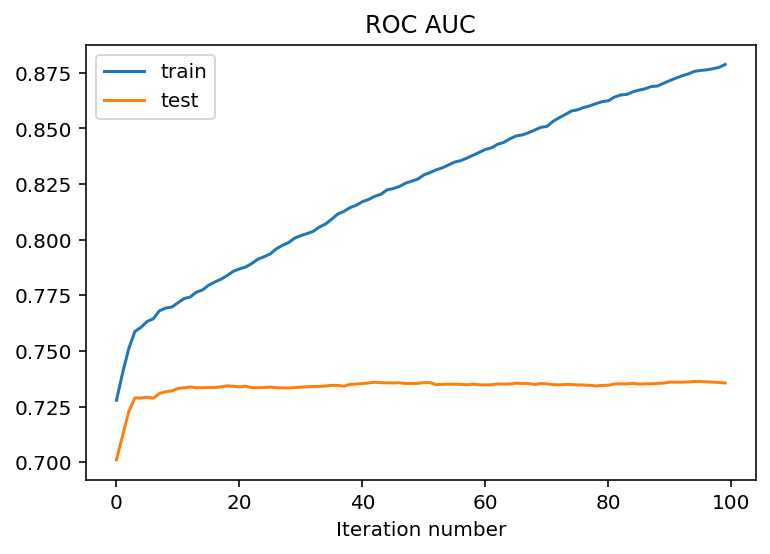

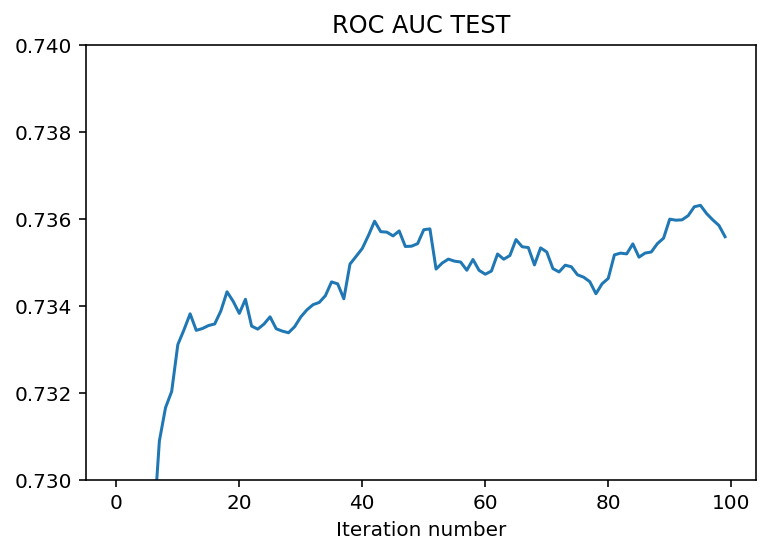

In [25]:
def save_online_metric(clf):
    return pd.DataFrame({'train': clf.evals_result()['validation_0']['auc'],
                         'test': clf.evals_result()['validation_1']['auc']})

res = save_online_metric(clf_xgb)
res.plot(title='ROC AUC')
plt.xlabel('Iteration number')
plt.figure()

res.test.plot(ylim=(.73, .74), title='ROC AUC TEST')
plt.xlabel('Iteration number')

Нужно побороть переобучение, уменьшим learning_rate. Так же уменьшим количество деревьев для уменьшения пере-
обучения

In [26]:
params = {'n_estimators': 50,
          'learning_rate': .05,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': .8,
          'colsample_bytree': .8,
          'n_jobs': -1}

clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

best_params = params

[0]	validation_0-auc:0.72781	validation_1-auc:0.70106
[1]	validation_0-auc:0.73980	validation_1-auc:0.71223
[2]	validation_0-auc:0.74980	validation_1-auc:0.72366
[3]	validation_0-auc:0.75613	validation_1-auc:0.72682
[4]	validation_0-auc:0.75871	validation_1-auc:0.72830
[5]	validation_0-auc:0.75958	validation_1-auc:0.72990
[6]	validation_0-auc:0.76029	validation_1-auc:0.72990
[7]	validation_0-auc:0.76304	validation_1-auc:0.73204
[8]	validation_0-auc:0.76401	validation_1-auc:0.73201
[9]	validation_0-auc:0.76424	validation_1-auc:0.73174
[10]	validation_0-auc:0.76500	validation_1-auc:0.73191
[11]	validation_0-auc:0.76500	validation_1-auc:0.73213
[12]	validation_0-auc:0.76597	validation_1-auc:0.73283
[13]	validation_0-auc:0.76660	validation_1-auc:0.73255
[14]	validation_0-auc:0.76700	validation_1-auc:0.73225
[15]	validation_0-auc:0.76764	validation_1-auc:0.73310
[16]	validation_0-auc:0.76831	validation_1-auc:0.73257
[17]	validation_0-auc:0.76872	validation_1-auc:0.73319
[18]	validation_0-au

Text(0.5, 0, 'Iteration number')

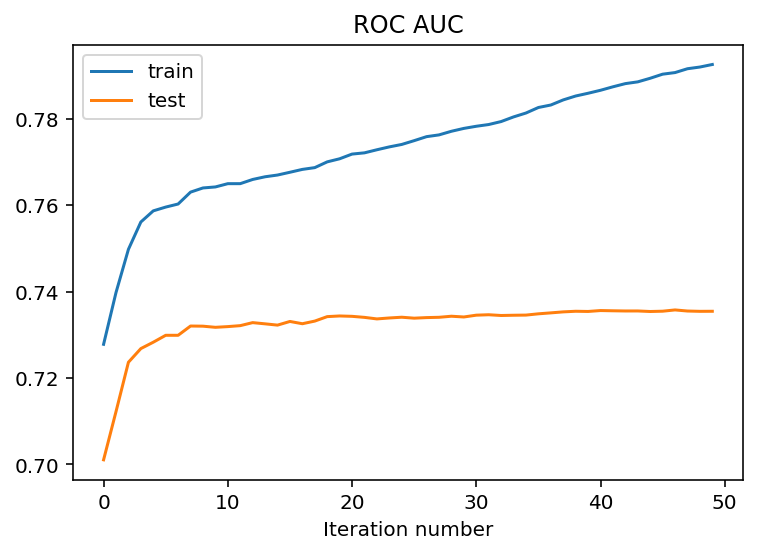

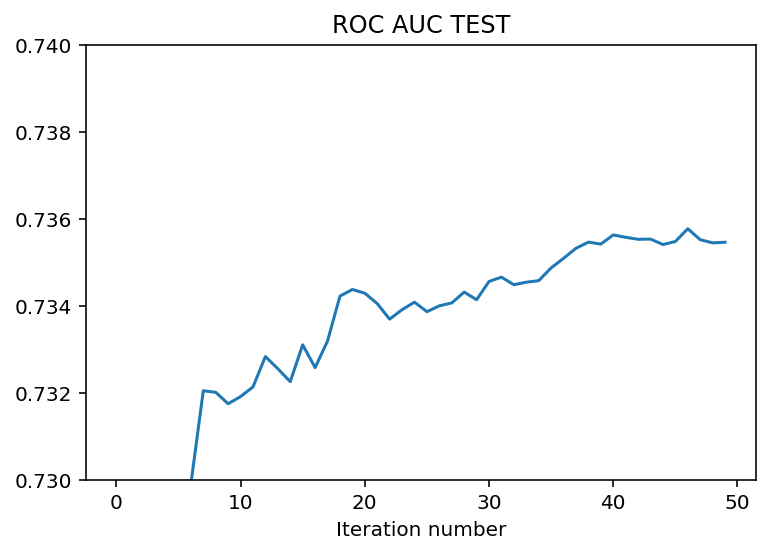

In [27]:
def save_online_metric(clf):
    return pd.DataFrame({'train': clf.evals_result()['validation_0']['auc'],
                         'test': clf.evals_result()['validation_1']['auc']})

res = save_online_metric(clf_xgb)
res.plot(title='ROC AUC')
plt.xlabel('Iteration number')
plt.figure()

res.test.plot(ylim=(.73, .74), title='ROC AUC TEST')
plt.xlabel('Iteration number')

#### Перебор параметров по сетке

Опишем функцию, похожую на GridSearchCV, только для одной отложенной выборки X_test. Она
перебирает параметры по заданной сетке и возвращает лучше по ROC AUC

In [28]:
def find_params(clf, param_grid):
    clf = GridSearchCV(clf, param_grid, scoring='roc_auc', 
                       cv=[(np.arange(len(X_train)),
                            np.arange(len(X_test)) + len(X_train))],
                       verbose=3)
    clf.fit(pd.concat([X_train, X_test]).values, pd.concat([y_train, y_test]).values)
    best_params = clf.best_estimator_.get_params()
    print('Best test ROC AUC:', clf.best_score_)
    print('Best params:', best_params)
    return best_params

**Процесс подбора параметров**

 1. Зафиксируем learning_rate и n_estimators, чтобы модель не переобучалась во время итераций
 2. Настраиваем параметры деревьев: max_depth и min_child_weight
 3. Настраиваем gamma (опционально)
 4. Настраиваем subsample и colsample_bytree
 5. Настраиваем регуляризацию reg_lambda и reg_alpha
 6. Уменьшаем learning_rate, увеличиваем количество деревьев и обучаем заново на лучших параметрах

**Подбираем max_depth и min_child_weight**

In [29]:
from sklearn.model_selection import GridSearchCV

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_child_weight': [10, 20, 100] # [1, 5, 10]
}


best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[18:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END ..max_depth=3, min_child_weight=10;, score=0.732 total time=   1.5s
[18:17:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END ..max_depth=3, min_child_weight=20;, score=0.732 total time=   1.5s
[18:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric 

 **Подбираем subsample и colsample_bytree**

In [30]:
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'subsample': np.linspace(.5, 1, 6),
    'colsample_bytree': np.linspace(.5, 1, 6)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[18:18:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END colsample_bytree=0.5, subsample=0.5;, score=0.736 total time=   1.4s
[18:18:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END colsample_bytree=0.5, subsample=0.6;, score=0.735 total time=   1.5s
[18:18:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation met

[CV 1/1] END colsample_bytree=0.8, subsample=0.7;, score=0.734 total time=   2.3s
[18:19:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END colsample_bytree=0.8, subsample=0.8;, score=0.736 total time=   2.4s
[18:19:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END colsample_bytree=0.8, subsample=0.9;, score=0.735 total time=   2.6s
[18:19:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the d

**Подбираем регуляризация: reg_lambda и rge_alpha**

In [31]:
best_params['subsample'] = .8
best_params['colsample_bytree'] = .8

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'reg_alpha': [0, .0001, .001, .1, 1],
    'reg_lambda': [0, .0001, .001, .1, 1]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[18:19:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END .........reg_alpha=0, reg_lambda=0;, score=0.736 total time=   2.4s
[18:19:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END ....reg_alpha=0, reg_lambda=0.0001;, score=0.736 total time=   2.4s
[18:19:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metri

[CV 1/1] END ....reg_alpha=1, reg_lambda=0.0001;, score=0.736 total time=   2.4s
[18:20:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END .....reg_alpha=1, reg_lambda=0.001;, score=0.736 total time=   2.4s
[18:20:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/1] END .......reg_alpha=1, reg_lambda=0.1;, score=0.736 total time=   2.4s
[18:20:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the defa

#### Уменьшим learning_rate

In [32]:
best_params['learning_rate'] = 0.01
best_params['n_estimators'] = 500

clf_xgb = xgb.XGBClassifier(**best_params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.72869	validation_1-auc:0.70054
[1]	validation_0-auc:0.73684	validation_1-auc:0.71275
[2]	validation_0-auc:0.74293	validation_1-auc:0.71954
[3]	validation_0-auc:0.74935	validation_1-auc:0.72599
[4]	validation_0-auc:0.75201	validation_1-auc:0.72743
[5]	validation_0-auc:0.75289	validation_1-auc:0.72774
[6]	validation_0-auc:0.75361	validation_1-auc:0.72809
[7]	validation_0-auc:0.75503	validation_1-auc:0.72988
[8]	validation_0-auc:0.75589	validation_1-auc:0.73111
[9]	validation_0-auc:0.75615	validation_1-auc:0.73127
[10]	validation_0-auc:0.75644	validation_1-auc:0.73127
[11]	validation_0-auc:0.75649	validation_1-auc:0.73107
[12]	validation_0-auc:0.75665	validation_1-auc:0.73109
[13]	validation_0-auc:0.75685	validation_1-auc:0.73177
[14]	validation_0-auc:0.75696	validation_1-auc:0.73249
[15]	validation_0-auc:0.75707	validation_1-auc:0.73285
[16]	validation_0-auc:0.75685	validation_1-auc:0.73257
[17]	validation_0-auc:0.75703	validation_1-auc:0.73267
[18]	validation_0-au

[149]	validation_0-auc:0.77382	validation_1-auc:0.73653
[150]	validation_0-auc:0.77395	validation_1-auc:0.73655
[151]	validation_0-auc:0.77408	validation_1-auc:0.73646
[152]	validation_0-auc:0.77416	validation_1-auc:0.73650
[153]	validation_0-auc:0.77428	validation_1-auc:0.73654
[154]	validation_0-auc:0.77447	validation_1-auc:0.73659
[155]	validation_0-auc:0.77455	validation_1-auc:0.73654
[156]	validation_0-auc:0.77472	validation_1-auc:0.73658
[157]	validation_0-auc:0.77482	validation_1-auc:0.73655
[158]	validation_0-auc:0.77491	validation_1-auc:0.73658
[159]	validation_0-auc:0.77506	validation_1-auc:0.73667
[160]	validation_0-auc:0.77517	validation_1-auc:0.73668
[161]	validation_0-auc:0.77526	validation_1-auc:0.73671
[162]	validation_0-auc:0.77538	validation_1-auc:0.73667
[163]	validation_0-auc:0.77551	validation_1-auc:0.73664
[164]	validation_0-auc:0.77555	validation_1-auc:0.73664
[165]	validation_0-auc:0.77564	validation_1-auc:0.73663
[166]	validation_0-auc:0.77579	validation_1-auc:

[296]	validation_0-auc:0.79046	validation_1-auc:0.73730
[297]	validation_0-auc:0.79064	validation_1-auc:0.73736
[298]	validation_0-auc:0.79074	validation_1-auc:0.73737
[299]	validation_0-auc:0.79089	validation_1-auc:0.73730
[300]	validation_0-auc:0.79096	validation_1-auc:0.73731
[301]	validation_0-auc:0.79107	validation_1-auc:0.73732
[302]	validation_0-auc:0.79114	validation_1-auc:0.73728
[303]	validation_0-auc:0.79129	validation_1-auc:0.73730
[304]	validation_0-auc:0.79143	validation_1-auc:0.73731
[305]	validation_0-auc:0.79151	validation_1-auc:0.73730
[306]	validation_0-auc:0.79156	validation_1-auc:0.73730
[307]	validation_0-auc:0.79163	validation_1-auc:0.73726
[308]	validation_0-auc:0.79169	validation_1-auc:0.73728
[309]	validation_0-auc:0.79180	validation_1-auc:0.73735
[310]	validation_0-auc:0.79190	validation_1-auc:0.73735
[311]	validation_0-auc:0.79199	validation_1-auc:0.73732
[312]	validation_0-auc:0.79209	validation_1-auc:0.73732
[313]	validation_0-auc:0.79213	validation_1-auc:

[443]	validation_0-auc:0.80686	validation_1-auc:0.73790
[444]	validation_0-auc:0.80693	validation_1-auc:0.73787
[445]	validation_0-auc:0.80703	validation_1-auc:0.73785
[446]	validation_0-auc:0.80714	validation_1-auc:0.73789
[447]	validation_0-auc:0.80725	validation_1-auc:0.73789
[448]	validation_0-auc:0.80729	validation_1-auc:0.73788
[449]	validation_0-auc:0.80736	validation_1-auc:0.73791
[450]	validation_0-auc:0.80750	validation_1-auc:0.73794
[451]	validation_0-auc:0.80764	validation_1-auc:0.73791
[452]	validation_0-auc:0.80772	validation_1-auc:0.73794
[453]	validation_0-auc:0.80786	validation_1-auc:0.73794
[454]	validation_0-auc:0.80789	validation_1-auc:0.73795
[455]	validation_0-auc:0.80794	validation_1-auc:0.73794
[456]	validation_0-auc:0.80806	validation_1-auc:0.73791
[457]	validation_0-auc:0.80817	validation_1-auc:0.73795
[458]	validation_0-auc:0.80824	validation_1-auc:0.73791
[459]	validation_0-auc:0.80831	validation_1-auc:0.73791
[460]	validation_0-auc:0.80839	validation_1-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.1, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

Визуализируем метрику в зависимости от итерации

Text(0.5, 0, 'iteration number')

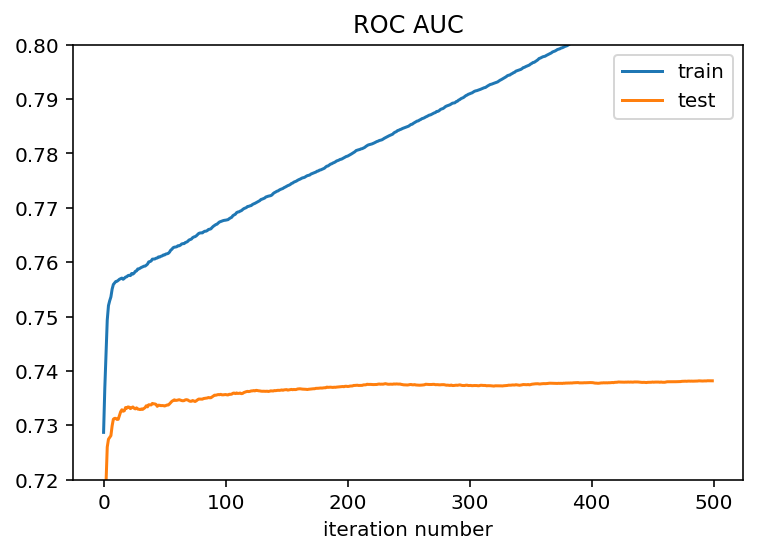

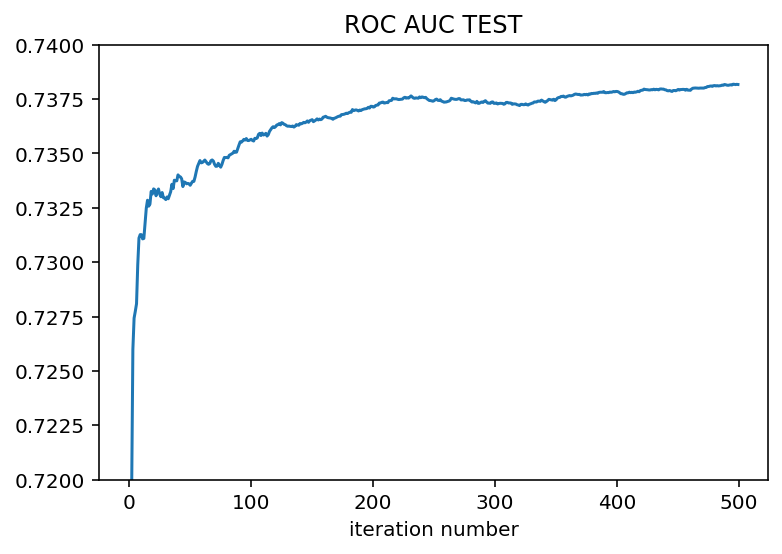

In [33]:
res = save_online_metric(clf_xgb)
res.plot(ylim=(0.72, 0.8), title='ROC AUC')
plt.xlabel('iteration number')
plt.figure()
res.test.plot(ylim=(0.72, 0.74), title='ROC AUC TEST')
plt.xlabel('iteration number')

### HyperOpt

http://hyperopt.github.io/hyperopt/

Инструмент для автоматической "умной" оптимизации большого числа гиперпараметров. Использует алгоритм Tree of Parzen Estimators

In [37]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
    
#функция, которую будем минимизировать
def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    print('Tracking with params: ', params)
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred_xgb_test = clf.predict_proba(X_test)[:, 1]
    auc = calc_auc(y_test, y_pred_xgb_test, prin=False)
    result = {'loss': 1-auc, 'status': STATUS_OK}
    print(f'TEST ROC AUC: {auc:.4f}')
    return result

space = {'max_depth': hp.quniform('max_depth', 1, 10, 1),
         'min_child_weight': hp.quniform('min_child_weigh', 1, 10, 1),
         'sub_sample': hp.quniform('sub_sample', .5, 1, .05),
         'gamma': hp.quniform('gamma', .5, 1, .05),
         'colsample_bytree': hp.quniform('colsample_bytree', .5, 1, .05),
         'silent': 1,
         'n_estimators': 50,
         'learning_rate': .03
        }

trials = Trials()

best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=50)

Tracking with params:                                                                                                  
{'colsample_bytree': 0.6000000000000001, 'gamma': 0.55, 'learning_rate': 0.03, 'max_depth': 2, 'min_child_weight': 8.0, 'n_estimators': 50, 'silent': 1, 'sub_sample': 0.9500000000000001, 'n_jobs': -1}
[18:40:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "silent", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:40:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'lo

TEST ROC AUC: 0.7332                                                                                                   
Tracking with params:                                                                                                  
{'colsample_bytree': 0.9, 'gamma': 0.75, 'learning_rate': 0.03, 'max_depth': 2, 'min_child_weight': 6.0, 'n_estimators': 50, 'silent': 1, 'sub_sample': 0.6000000000000001, 'n_jobs': -1}
[18:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "silent", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0

TEST ROC AUC: 0.7331                                                                                                   
Tracking with params:                                                                                                  
{'colsample_bytree': 0.9500000000000001, 'gamma': 0.5, 'learning_rate': 0.03, 'max_depth': 1, 'min_child_weight': 6.0, 'n_estimators': 50, 'silent': 1, 'sub_sample': 0.7000000000000001, 'n_jobs': -1}
[18:41:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "silent", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:41:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in

TEST ROC AUC: 0.7342                                                                                                   
Tracking with params:                                                                                                  
{'colsample_bytree': 0.75, 'gamma': 0.65, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 5.0, 'n_estimators': 50, 'silent': 1, 'sub_sample': 1.0, 'n_jobs': -1}
[18:41:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "silent", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:41:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default 

TEST ROC AUC: 0.7341                                                                                                   
Tracking with params:                                                                                                  
{'colsample_bytree': 0.55, 'gamma': 0.7000000000000001, 'learning_rate': 0.03, 'max_depth': 1, 'min_child_weight': 10.0, 'n_estimators': 50, 'silent': 1, 'sub_sample': 1.0, 'n_jobs': -1}
[18:41:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "silent", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:41:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.

TEST ROC AUC: 0.7274                                                                                                   
Tracking with params:                                                                                                  
{'colsample_bytree': 0.75, 'gamma': 0.9, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 1.0, 'n_estimators': 50, 'silent': 1, 'sub_sample': 0.7000000000000001, 'n_jobs': -1}
[18:42:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "silent", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:42:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0

TEST ROC AUC: 0.7311                                                                                                   
Tracking with params:                                                                                                  
{'colsample_bytree': 0.9500000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 2.0, 'n_estimators': 50, 'silent': 1, 'sub_sample': 0.9500000000000001, 'n_jobs': -1}
[18:42:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "silent", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:42:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:11

TEST ROC AUC: 0.7350                                                                                                   
Tracking with params:                                                                                                  
{'colsample_bytree': 0.65, 'gamma': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 4.0, 'n_estimators': 50, 'silent': 1, 'sub_sample': 1.0, 'n_jobs': -1}
[18:43:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:                   
Parameters: { "silent", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:43:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default e

In [38]:
best

{'colsample_bytree': 0.7000000000000001,
 'gamma': 0.9,
 'max_depth': 5.0,
 'min_child_weigh': 1.0,
 'sub_sample': 1.0}

In [39]:
trials.best_trial

{'state': 2,
 'tid': 46,
 'spec': None,
 'result': {'loss': 0.264645292364557, 'status': 'ok'},
 'misc': {'tid': 46,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [46],
   'gamma': [46],
   'max_depth': [46],
   'min_child_weigh': [46],
   'sub_sample': [46]},
  'vals': {'colsample_bytree': [0.7000000000000001],
   'gamma': [0.9],
   'max_depth': [5.0],
   'min_child_weigh': [1.0],
   'sub_sample': [1.0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 12, 4, 15, 42, 53, 481000),
 'refresh_time': datetime.datetime(2021, 12, 4, 15, 42, 56, 8000)}

## Важность признаков

#### Встроенные методы

    Нужно вытащить из sklearn обертки оригинальный объект класса xgboost.core.Booster
    
    Есть 3 типа важности в get_score()
    
        weight - суммарное количество раз, когда признак использовался для разбиения вершины
        gain - средний прирост качество, когда признак использовался для разбиения вершины
        cover - среднее количество, которые попадали в разюиение по признаку, когда он использовался
        для разбиения вершины

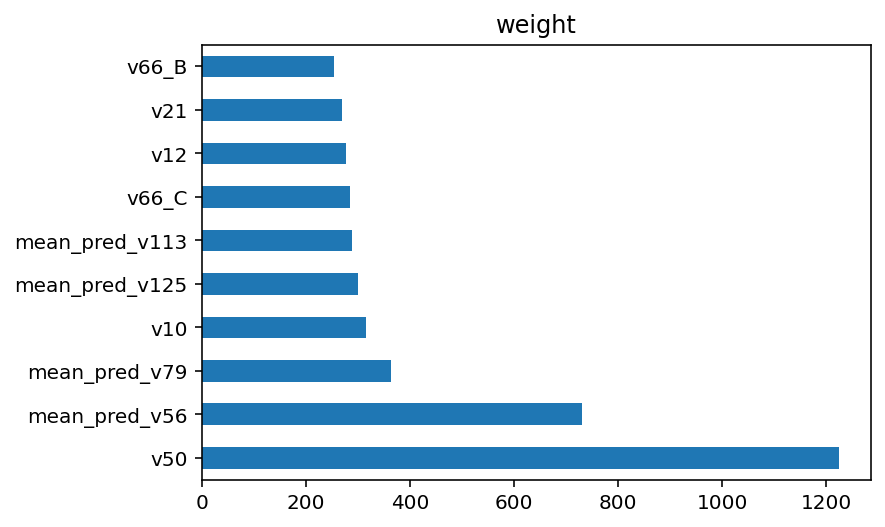

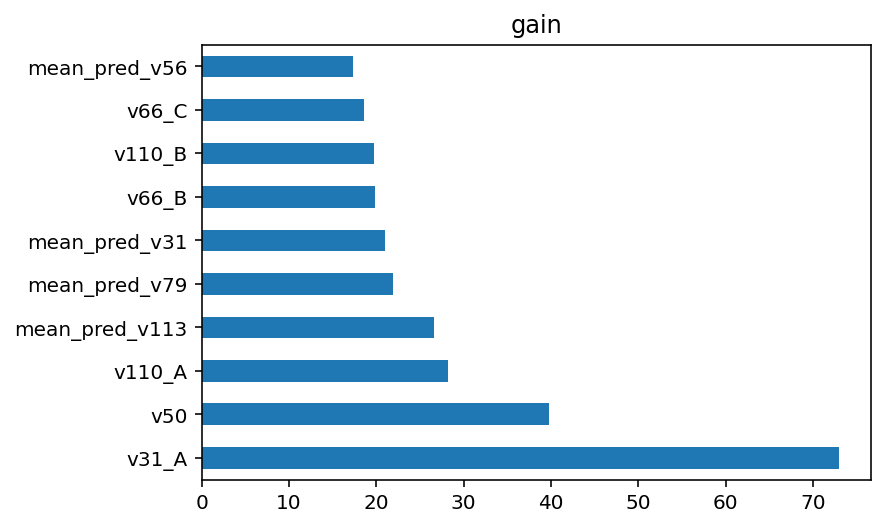

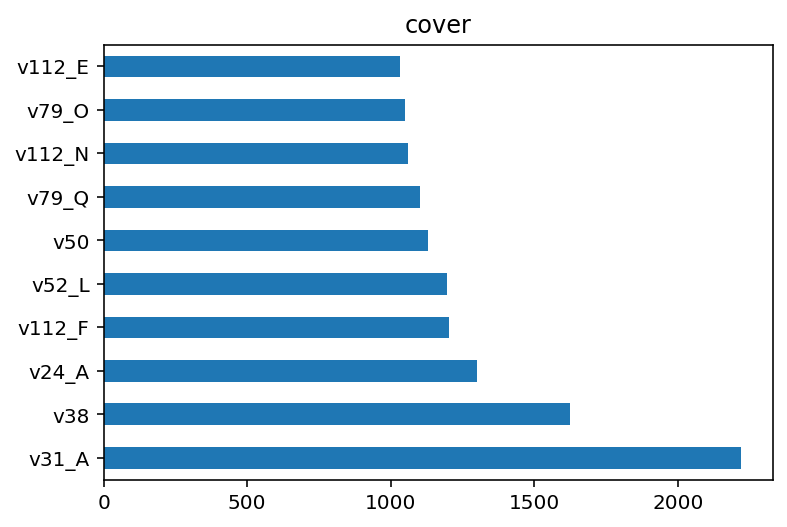

In [42]:
bst = clf_xgb.get_booster()

for kind in ['weight', 'gain', 'cover']:
    imp = pd.Series(bst.get_score(importance_type=kind))
    plt.figure()
    imp.sort_values(ascending=False).iloc[:10].plot(kind='barh', title=kind)


### XGBFI

Позволяет оценивать важности взаимодействия признаков

https://github.com/limexp/xgbfir

In [52]:
import xgbfir
xgbfir.saveXgbFI(clf_xgb, OutputXlsxFile='xgbfi_report.xlsx')

In [51]:
pd.read_excel('xgbfi_report.xlsx', sheet_name=1)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,mean_pred_v113|v50,32452.609752,147,43.138302,0.293458,220.766053,11339.672502,1,1,1,11,2,1,2.833333,44.394558,1.775510
1,mean_pred_v56|v50,15980.496537,106,29.776658,0.280912,150.759401,6768.488785,2,3,2,13,6,3,4.833333,49.132075,2.169811
2,mean_pred_v31|v50,11952.592356,77,21.393674,0.277840,155.228472,5206.674564,3,4,4,14,5,4,5.666667,40.597403,1.974026
3,v50|v50,11918.384587,53,21.890535,0.413029,224.875181,6900.943693,4,6,3,2,1,2,3.000000,47.396226,1.905660
4,v50|v66_B,9067.735730,129,12.058842,0.093479,70.292525,852.133841,5,2,6,73,29,10,20.833333,44.860465,3.255814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,v12|v50,142.655464,8,0.833327,0.104166,17.831933,15.836906,96,57,60,67,98,86,77.333333,52.875000,3.750000
96,mean_pred_v47|v12,140.084310,4,0.627350,0.156837,35.021078,31.297199,97,90,76,40,69,61,72.166667,60.500000,4.000000
97,mean_pred_v125|v66_C,139.339676,4,0.303031,0.075758,34.834919,10.258600,98,91,92,85,70,93,88.166667,37.000000,3.500000
98,v114|v66_B,138.491896,6,0.447559,0.074593,23.081983,9.844472,99,74,85,86,89,94,87.833333,46.500000,3.666667


# Домашняя работа

#### Простая
1. Решаем ту же задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Используем **objective = "reg:linear"** в xgboost
5. Провести настройку гиперпараметров, используя либо hyperopt либо ручную настройку, как вам больше нравится
6. Использовать отложенную выборку (как на занятии), чтобы следить за процессом обучения xgboost'а, но, как и в предыдущем домашнем задании, финальную оценку качества давать используя 10-fold кросс-валидацию.
4. Проанализировать, насколько согласованы оценка на отложенной выборке и на кросс-валидации (одновременно уменьшаются/увеличиваются при изменении гиперпараметров или ведут себя по-разному)
5. Проанализировать признаки, используя XGBFI, сделать выводы об интересных взаимодействиях
7. В качестве решения:
    Jupyter notebook с кодом и комментариями